# Bonus1: Parallel Algorithms

### Name: [RUI LI]


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Parallel/Parallel.pdf)

2. Implement federated averaging or decentralized optimization.

3. Plot the convergence curve. (The x-axis can be ```number of epochs``` or ```number of communication```. You must make sure the label is correct.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo. (If it is submitted to Google Drive or Dropbox, you must make the file open-access.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus1/Bonus1.html



# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [1]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [2]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [3]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[-0.07267184  0.04649293  0.13109318  0.04469095  0.16252196  0.06684934
  -0.03917188  0.00818071]]
test std = 
[[0.98303553 0.95915079 0.75148158 1.0508269  1.2753261  0.92527492
  1.09419222 1.0512543 ]]


## 1.4. Add a dimension of all ones

In [4]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


## WORKER

In [5]:

class Worker:
    def __init__(self,x,y):
        self.x = x #  s−by−d l o c a l f e a t u r e ma tr
        self.y = y  # 1−by−d l o c a l f e a t u r e ma tr
        self.s = x.shape[0] #number of local samples
        self.d = x.shape[1] #number of featrues
        self.w = numpy.zeros((d,1)) #d by 1 model parameter vector
        
    def set_param(self,w):
        self.w = w
        
    def loss(self):
        yx = numpy.multiply(self.y, self.x) #s by d matrix
        yxw = numpy.dot(yx, self.w) 
        vec1 = numpy.exp(-yxw)
        vec2 = numpy.log(1 + vec1)
        return numpy.sum(vec2)
    
    def gradient(self,lam):
        yx = numpy.multiply(self.y, self.x) #s by d matrix
        yxw = numpy.dot(yx, self.w) #s by 1
        vec1 = numpy.exp(yxw) #s by 1
        vec2 = numpy.divide(yx, 1+vec1) #s by d
        #g = -numpy.sum(vec2, axis = 0).reshape(self.d, 1) #d by 1
        vec3 = -numpy.mean(vec2, axis=0).reshape(self.d, 1) # d-by-1 matrix
        g = vec3 + lam * self.w
        return g
    
    def grad_descent(self, q, lam, stepsize):
        for t in range(q):
            self.w -= stepsize * self.gradient(lam)
        return self.w
    
    def stochastic_gradient(self,xi, yi,lam):
        yx = yi * xi # 1-by-d matrix
        yxw = float(numpy.dot(yx, self.w)) # scalar
        g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
        g = g_loss + lam * self.w # d-by-1 matrix
        return g
    
    def s_grad_descent(self, q, lam, stepsize):
        for t in range(q):
            # randomly shuffle the samples
            rand_indices = numpy.random.permutation(self.s)
            x_rand = self.x[rand_indices, :]
            y_rand = self.y[rand_indices, :]

            for i in range(self.s):
                xi = x_rand[i, :] # 1-by-d matrix
                yi = float(y_rand[i, :]) # scalar
                g = self.stochastic_gradient(xi, yi, lam)
                self.w -= stepsize * g
            stepsize *= 0.9 # decrease step size
        return self.w        
        

## SERVER

In [6]:
class Server:
    def __init__(self, m, n, d):
        self.m = m # #of worker nodes
        self.n = n # #of training samples
        self.d = d # #of features
        self.w = numpy.zeros((d, 1)) # d by 1 model parameter vector
#       self.g = numpy.zeros((d, 1)) # d by 1 gradient
#       self.v = numpy.zeros((d, 1)) # d by 1 momentum
        self.p = numpy.zeros((d, 1)) # d by 1 direction
        self.loss = 0
        self.obj = 0
        
    def broadcast(self):
        return self.w
    
    def aggregate(self, ps, losses):
        self.p = numpy.zeros((self.d, 1))
        self.loss = 0
        for k in range(self.m):
            self.p += ps[k]
            self.loss += losses[k]
        self.p /= self.m
        
#     def gradient(self, lam):
#         self.g = self.g / self.n + lam * self.w
        
    def objective(self, lam):
        reg = lam/ 2 * numpy.sum(self.w * self.w)
        self.obj = self.loss / self.n + reg 
        return self.obj
    
#     def agd(self,alpha,beta):
#         self.v *= beta
#         self.v += self.g
#         self.w -= alpha * self.v
        
    def gd(self,alpha):
        self.w -= alpha * self.p    

## INITIALIZATION

In [7]:
import math

#create a server and m worker nodes
def create_server_workers(m, x, y):
    n,d = x.shape
    s = math.floor(n / m)
    server = Server(m, n, d)
    workers = []
    
    for i in range(m):
        indices = list(range(int(i * s), int((i+1)*s)))
        worker = Worker(x[indices, :], y[indices, :])
        workers.append(worker)
    return server, workers

m =4

## TEST GD

In [8]:
def test_gd(max_epoch, alpha, lam, q, stepsize):
    objvals = numpy.zeros(max_epoch) # store the objective values
    for t in range(max_epoch):
        #broadcast
        w = server.broadcast()
        for i in range(m):
            workers[i].set_param(w)
        #worker local computation
        ps = []
        losses = []
        for i in range(m):
            p = workers[i].grad_descent(q,lam, stepsize)
            ps.append(p)
            l = workers[i].loss()
            losses.append(l)

        #server aggregate the workers' output
        server.aggregate(ps, losses)

        #server update model params
        #server.gradient(lam) #compute gradient
        obj = server.objective(lam) #compute objective function
        print('epoch ' + str(t) + ' Objective function value  = ' + str(obj))
        objvals[t] = obj
        alpha /= numpy.sqrt(t+1) #decrease alpha
        server.gd(alpha) # update model parameters
        
    return objvals, server.broadcast()
    

In [9]:
#GD with q = 1

lam = 1E-6
alpha = 0.1
worker_stepsize = 0.1
max_epoch = 100
q = 1 # #of GD performed

server, workers = create_server_workers(m, x_train, y_train)
objvals_gd_q1,w = test_gd(max_epoch, alpha, lam, q, worker_stepsize ) # store the objective values

epoch 0 Objective function value  = 0.6624636298306982
epoch 1 Objective function value  = 0.6281674445213977
epoch 2 Objective function value  = 0.6032487475219407
epoch 3 Objective function value  = 0.5832744351716677
epoch 4 Objective function value  = 0.5666368619403179
epoch 5 Objective function value  = 0.5527196625033943
epoch 6 Objective function value  = 0.5411170447459196
epoch 7 Objective function value  = 0.5314453588328238
epoch 8 Objective function value  = 0.5233463926399013
epoch 9 Objective function value  = 0.516512972540472
epoch 10 Objective function value  = 0.5106972693205204
epoch 11 Objective function value  = 0.5057053445169909
epoch 12 Objective function value  = 0.5013868000239176
epoch 13 Objective function value  = 0.49762460497938205
epoch 14 Objective function value  = 0.49432682758794916
epoch 15 Objective function value  = 0.4914204045978116
epoch 16 Objective function value  = 0.48884657314120267
epoch 17 Objective function value  = 0.4865575356819898


In [10]:
# Predict class label
# Inputs:
#     w: d-by-1 matrix
#     X: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f
# evaluate training error
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Training classification error is 0.2125
Test classification error is 0.25


In [11]:
#GD q = 8
lam = 1E-6
alpha = 0.1
worker_stepsize = 0.1
max_epoch = 100
q = 8 # #of GD performed

server, workers = create_server_workers(m, x_train, y_train)
objvals_gd_q8,w = test_gd(max_epoch, alpha, lam, q, worker_stepsize) # store the objective values

epoch 0 Objective function value  = 0.5596906876244937
epoch 1 Objective function value  = 0.5022591413502447
epoch 2 Objective function value  = 0.48362672542885055
epoch 3 Objective function value  = 0.47438404070638945
epoch 4 Objective function value  = 0.4690916403579224
epoch 5 Objective function value  = 0.4659622219267671
epoch 6 Objective function value  = 0.46411139799900253
epoch 7 Objective function value  = 0.4630185897595177
epoch 8 Objective function value  = 0.4623709770323832
epoch 9 Objective function value  = 0.46198405305817064
epoch 10 Objective function value  = 0.4617505406339876
epoch 11 Objective function value  = 0.4616082028934459
epoch 12 Objective function value  = 0.46152067788552187
epoch 13 Objective function value  = 0.4614664711000639
epoch 14 Objective function value  = 0.46143271249201073
epoch 15 Objective function value  = 0.4614116032111855
epoch 16 Objective function value  = 0.4613983684854272
epoch 17 Objective function value  = 0.4613900600675

In [12]:
# evaluate training error
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Training classification error is 0.2078125
Test classification error is 0.25


## TEST SGD

In [13]:
def test_sgd(max_epoch, alpha, lam, q, stepsize):
    objvals = numpy.zeros(max_epoch) # store the objective values
    for t in range(max_epoch):
        #broadcast
        w = server.broadcast()
        for i in range(m):
            workers[i].set_param(w)
        #worker local computation
        ps = []
        losses = []
        for i in range(m):
            p = workers[i].s_grad_descent(q,lam, stepsize)
            ps.append(p)
            l = workers[i].loss()
            losses.append(l)

        #server aggregate the workers' output
        server.aggregate(ps, losses)

        #server update model params
        #server.gradient(lam) #compute gradient
        obj = server.objective(lam) #compute objective function
        print('epoch ' + str(t) + ' Objective function value  = ' + str(obj))
        objvals[t] = obj
        alpha /= numpy.sqrt(t+1) #decrease alpha
        server.gd(alpha) # update model parameters
        
    return objvals,server.broadcast()

In [14]:
#SGD with q = 1

lam = 1E-6
alpha = 0.1
worker_stepsize = 0.001 
max_epoch = 100
q = 1 # #of SGD performed

server, workers = create_server_workers(m, x_train, y_train)
objvals_sgd_q1,w = test_sgd(max_epoch, alpha, lam, q, worker_stepsize ) # store the objective values

epoch 0 Objective function value  = 0.6481260049084705
epoch 1 Objective function value  = 0.6031919677570566
epoch 2 Objective function value  = 0.5743642830241193
epoch 3 Objective function value  = 0.5532646060299135
epoch 4 Objective function value  = 0.5368193499699637
epoch 5 Objective function value  = 0.5238538007790192
epoch 6 Objective function value  = 0.5136027033761911
epoch 7 Objective function value  = 0.5054442049771808
epoch 8 Objective function value  = 0.49889889839138496
epoch 9 Objective function value  = 0.49357951736207983
epoch 10 Objective function value  = 0.4892192151854582
epoch 11 Objective function value  = 0.4856014133971343
epoch 12 Objective function value  = 0.48258269058258196
epoch 13 Objective function value  = 0.4800344272239065
epoch 14 Objective function value  = 0.47787281072128013
epoch 15 Objective function value  = 0.47602135354399927
epoch 16 Objective function value  = 0.4744281710698625
epoch 17 Objective function value  = 0.47306372376322

In [15]:
# evaluate training error
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Training classification error is 0.2140625
Test classification error is 0.25


In [16]:
#SGD q = 8
lam = 1E-6
alpha = 0.1
worker_stepsize = 0.001 
max_epoch = 100
q = 8 # #of SGD performed

server, workers = create_server_workers(m, x_train, y_train)
objvals_sgd_q8,w = test_sgd(max_epoch, alpha, lam, q, worker_stepsize) # store the objective values

epoch 0 Objective function value  = 0.5523785178996501
epoch 1 Objective function value  = 0.4965131665182021
epoch 2 Objective function value  = 0.47956973879610537
epoch 3 Objective function value  = 0.4715026145271234
epoch 4 Objective function value  = 0.4670371007904076
epoch 5 Objective function value  = 0.4644975224995644
epoch 6 Objective function value  = 0.4630490226856956
epoch 7 Objective function value  = 0.4622458828030027
epoch 8 Objective function value  = 0.4617761840943457
epoch 9 Objective function value  = 0.4615218138998982
epoch 10 Objective function value  = 0.46136164407635294
epoch 11 Objective function value  = 0.4612782430142146
epoch 12 Objective function value  = 0.46122245644652615
epoch 13 Objective function value  = 0.4611948584511554
epoch 14 Objective function value  = 0.46118576393570626
epoch 15 Objective function value  = 0.46117338067977753
epoch 16 Objective function value  = 0.4611650504613744
epoch 17 Objective function value  = 0.46116188702859

In [17]:
# evaluate training error
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Training classification error is 0.2078125
Test classification error is 0.25


## PLOT GD vs SGD

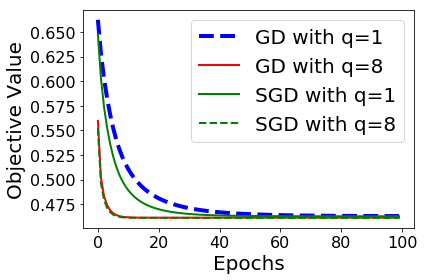

In [18]:
# plot the 4 curves:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd_q1 = range(len(objvals_gd_q1))
epochs_gd_q8 = range(len(objvals_gd_q8))
epochs_sgd_q1 = range(len(objvals_sgd_q1))
epochs_sgd_q8 = range(len(objvals_sgd_q8))

line0, = plt.plot(epochs_gd_q1, objvals_gd_q1, '--b', LineWidth=4)
line1, = plt.plot(epochs_gd_q8, objvals_gd_q8, '-r', LineWidth=2)
line2, = plt.plot(epochs_sgd_q1, objvals_sgd_q1, '-g', LineWidth=2)
line3, = plt.plot(epochs_sgd_q8, objvals_sgd_q8, '--g', LineWidth=2)

plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1, line2, line3], ['GD with q=1', 'GD with q=8', 'SGD with q=1', 'SGD with q=8'], fontsize=20)

plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)